In [1]:
import tensorflow as tf
import numpy as np
from DP import DataLoader
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
d = DataLoader(data_name = "YRD20",mode = 'reg',p_day = 10,train_prob = 0.8)

In [3]:
dx = d(p_type = 'high')

In [4]:
d2 = DataLoader(data_name="RH20",mode = 'reg',p_day = 10,train_prob = 0.8)
d3 = DataLoader(data_name="MMM20",mode = 'reg',p_day = 10,train_prob = 0.8)

In [5]:
dx2 = d2(p_type = 'high')
dx3 = d3(p_type = 'high')

In [6]:
dx3["X_tr"].shape

(9604, 10, 19, 12)

In [7]:
X_tr = np.concatenate((dx2["X_tr"],dx["X_tr"],dx3["X_tr"]))
Y_tr = np.concatenate((dx2["Y_tr"],dx["Y_tr"],dx3["Y_tr"])).reshape(-1,1)

In [9]:
X_te = np.concatenate((dx2["X_te"],dx["X_te"],dx3["X_te"]))
Y_te = np.concatenate((dx2["Y_te"],dx["Y_te"],dx3["Y_te"])).reshape(-1,1)

In [10]:
class ACT_0:
    def __init__(self,inp,**args):
        try:
            self.name = args["name"]
        except:
            self.name = "def_act"
        self.x = inp
        self.bshape = inp.shape[1:]
        self.r = tf.get_variable(self.name+"_r",shape = self.bshape,initializer=tf.contrib.layers.xavier_initializer())
        self.lr = tf.get_variable(self.name+"_lr",shape = self.bshape,initializer=tf.contrib.layers.xavier_initializer())
        self.oup = (tf.nn.tanh(self.x)*tf.nn.sigmoid(self.r)+tf.nn.relu(self.x)*(1-tf.nn.sigmoid(self.r)))*self.lr
    def __call__(self):
        return self.oup

In [52]:
class BN:
    def update(self):
        ema_apply_op = self.ema.apply([self.mean,self.var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(self.mean),tf.identity(self.var)
    def __call__(self):
        return self.oup
    def __init__(self,inp,**args):
        self.nD = len(inp.shape)
        try:
            self.name = args["name"]
        except:
            self.name = "def"
        try:
            self.axes = args["axes"]
        except:
            self.axes = list(range(self.nD-1))
        self.mean,self.var = tf.nn.moments(inp,axes = self.axes)
        self.scale = tf.get_variable(self.name+"scale",shape=inp.shape[1:],initializer=tf.contrib.layers.xavier_initializer())
        self.shift = tf.get_variable(self.name+"_shift",shape=inp.shape[1:],initializer=tf.contrib.layers.xavier_initializer())
        
        try:
            self.epsilon = args["epsilon"]
        except:
            self.epsilon = 10e-5
        try:
            self.ema = tf.train.ExponentialMovingAverage(decay=args["decay"])
        except:
            self.ema = tf.train.ExponentialMovingAverage(decay=0.9)
        self.mean,self.var = self.update()
        self.oup = tf.nn.batch_normalization(inp,self.mean,self.var,self.shift,self.scale,self.epsilon)

In [12]:
class model_0:
    #inp - conv - conv - pool - conv - fc
    def __init__(self,**args):
        self.X = tf.placeholder(shape=[None,10,19,12],dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None,1],dtype=tf.float32)
        ##L1
        self.W1 = tf.get_variable("W1",shape=[3,3,12,16],initializer=tf.contrib.layers.xavier_initializer())
        self.Z1 = tf.nn.conv2d(self.X,self.W1,strides=[1,1,1,1],padding="VALID")
        self.b1 = tf.get_variable("b1",shape=[8,17,16],initializer=tf.zeros_initializer())
        self.R1 = tf.get_variable("R1",shape=[8,17,16],initializer=tf.contrib.layers.xavier_initializer())
        self.LR1 = tf.get_variable("LR1",shape=[8,17,16],initializer=tf.contrib.layers.xavier_initializer())
        self.A1 = actfunc(self.Z1+self.b1,self.R1,self.LR1)
        ##L2
        self.W2 = tf.get_variable("W2",shape=[3,3,16,20],initializer=tf.contrib.layers.xavier_initializer())
        self.Z2 = tf.nn.conv2d(self.A1,self.W2,strides=[1,1,1,1],padding="VALID")
        self.b2 = tf.get_variable("b2",shape=[6,15,20],initializer=tf.zeros_initializer())
        self.R2 = tf.get_variable("R2",shape=[6,15,20],initializer=tf.contrib.layers.xavier_initializer())
        self.LR2 = tf.get_variable("LR2",shape=[6,15,20],initializer=tf.contrib.layers.xavier_initializer())
        self.A2 = actfunc(self.Z2+self.b2,self.R2,self.LR2)
        ##avg pool
        self.Pavg1 = tf.nn.avg_pool(self.A2,strides=[1,3,3,1],ksize=[1,3,3,1],padding="VALID")
        ##L3
        self.W3 = tf.get_variable("W3",shape=[2,2,20,10],initializer=tf.contrib.layers.xavier_initializer())
        self.Z3 = tf.nn.conv2d(self.Pavg1,self.W3,strides=[1,1,1,1],padding="VALID")
        self.b3 = tf.get_variable("b3",shape=[1,4,10],initializer=tf.zeros_initializer())
        self.R3 = tf.get_variable("R3",shape=[1,4,10],initializer=tf.contrib.layers.xavier_initializer())
        self.LR3 = tf.get_variable("LR3",shape=[1,4,10],initializer=tf.contrib.layers.xavier_initializer())
        self.A3 = actfunc(self.Z3+self.b3,self.R3,self.LR3)
        ##flatten
        self.F = tf.contrib.layers.flatten(self.A3)
        ##L4
        self.W4 = tf.get_variable("W4",shape=[40,15],initializer=tf.contrib.layers.xavier_initializer())
        self.Z4 = tf.matmul(self.F,self.W4)
        self.b4 = tf.get_variable("b4",shape=[1,15],initializer=tf.zeros_initializer())
        self.R4 = tf.get_variable("R4",shape=[1,15],initializer=tf.contrib.layers.xavier_initializer())
        self.LR4 = tf.get_variable("LR4",shape=[1,15],initializer=tf.contrib.layers.xavier_initializer())
        self.A4 = actfunc(self.Z4+self.b4,self.R4,self.LR4)
        ##L5(final oup)
        self.W5 = tf.get_variable("W5",shape=[15,1],initializer=tf.contrib.layers.xavier_initializer())
        self.Z5 = tf.matmul(self.A4,self.W5)
        self.b5 = tf.get_variable("b5",shape=[1,1],initializer=tf.zeros_initializer())
        self.R5 = tf.get_variable("R5",shape=[1,1],initializer=tf.contrib.layers.xavier_initializer())
        self.LR5 = tf.get_variable("LR5",shape=[1,1],initializer=tf.contrib.layers.xavier_initializer())
        self.OUP = actfunc(self.Z5,self.R5,self.LR5)
        ##misc
        self.lrr = tf.placeholder(dtype=tf.float32)
        self.cost = tf.reduce_mean(tf.squared_difference(100*self.Y,100*self.OUP))
        self.optimizer = tf.train.AdadeltaOptimizer(self.lrr).minimize(self.cost)
        self.init = tf.global_variables_initializer()
    def open(self,ini = True):
        self.sess = tf.Session()
        if ini:
            self.sess.run(self.init)
    def train(self,X,Y,lr=0.02,loop=3000):
        loss = []
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        for i in range(loop):
            _,cost_ = self.sess.run([self.optimizer,self.cost],feed_dict={self.X:X,self.Y:Y,self.lrr:lr})
            loss.append(cost_)
            if len(loss)>150:
                loss = loss[1:]
            ax.clear()
            ax.plot(loss)
            fig.canvas.draw()
    def minib_train(self,X,Y,lr=0.02,bloop = 30,bsize = 512):
        L = X.shape[0]
        loss = []
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        
        loop = int(1.8*(L/bsize))
        print("loop: "+str(loop),"total: "+str(loop*bloop))
        for i in range(loop):
            idx = np.random.choice(range(L),size = bsize)
            X_ = X[idx,:,:,:]
            Y_ = Y[idx,:]
            for b in range(bloop):
                _,cost_ = self.sess.run([self.optimizer,self.cost],feed_dict={self.X:X_,self.Y:Y_,self.lrr:lr})
                loss.append(cost_)
                if len(loss) >150:
                    loss = loss[1:]
                ax.clear()
                ax.plot(loss)
                fig.canvas.draw()
    def test(self,X,Y):
        return self.sess.run(self.cost,feed_dict={self.X:X,self.Y:Y})
    def save(self,name = 'model_0'):
        sv = tf.train.Saver()
        sv.save(self.sess,name)
    def load(self,name = 'model_0'):
        sv = tf.train.Saver()
        sv.restore(self.sess,name)
    def close(self):
        self.sess.close()
        tf.reset_default_graph()
        

In [13]:
class model_0A:
    #inp - BN - conv - BN - conv - BN - avg pool - BN - FC
    def __init__(self,**args):

        self.X = tf.placeholder(shape=[None,10,19,12],dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None,1],dtype=tf.float32)
        
        self.BNX = BN(self.X,name = "BN0")()
        self.W1 = tf.get_variable("W1",shape=[3,3,12,16],initializer=tf.contrib.layers.xavier_initializer())
        self.Z1 = tf.nn.conv2d(self.BNX,self.W1,strides = [1,1,1,1],padding="VALID")
        self.b1 = tf.get_variable("b1",shape=[8,17,16],initializer=tf.zeros_initializer())
        self.A1 = ACT_0(self.Z1+self.b1,name = "A1")()
        
        self.BNA1 = BN(self.A1,name="BNA1")()
        self.W2 = tf.get_variable("W2",shape=[3,3,16,20],initializer=tf.contrib.layers.xavier_initializer())
        self.Z2 = tf.nn.conv2d(self.BNA1,self.W2,strides = [1,1,1,1],padding="VALID")
        self.b2 = tf.get_variable("b2",shape=[6,15,20],initializer=tf.zeros_initializer())
        self.A2 = ACT_0(self.Z2+self.b2,name="A2")()
        
        self.BNA2 = BN(self.A2,name="BNA2")()
        self.Pavg1 = tf.nn.avg_pool(self.BNA2,strides=[1,3,3,1],ksize=[1,3,3,1],padding="VALID")
        
        self.BNPa = BN(self.Pavg1,name="BNAvg")()
        self.W3 = tf.get_variable("W3",shape=[2,2,20,10],initializer=tf.contrib.layers.xavier_initializer())
        self.Z3 = tf.nn.conv2d(self.BNPa,self.W3,strides=[1,1,1,1],padding="VALID")
        self.b3 = tf.get_variable("b3",shape=[1,4,10])
        self.A3 = ACT_0(self.Z3+self.b3,name="A3")()
        
        self.BNA3 = BN(self.A3,name="BNA3")()
        self.F = tf.contrib.layers.flatten(self.BNA3)
        self.W4 = tf.get_variable("W4",shape=[40,15],initializer=tf.contrib.layers.xavier_initializer())
        self.Z4 = tf.matmul(self.F,self.W4)
        self.b4 = tf.get_variable("b4",shape=[1,15],initializer=tf.zeros_initializer())
        self.A4 = ACT_0(self.Z4+self.b4,name="A4")()
        
        self.BNA4 = BN(self.A4,name="BNA4")()
        self.W5 = tf.get_variable("W5",shape=[15,1],initializer=tf.contrib.layers.xavier_initializer())
        self.Z5 = tf.matmul(self.BNA4,self.W5)
        self.b5 = tf.get_variable("b5",shape=[1,1],initializer=tf.zeros_initializer())
        self.OUP = ACT_0(self.Z5+self.b5,name="OUP")()
        
        self.cost = tf.reduce_mean(tf.squared_difference(100*self.Y,100*self.OUP))
        self.optimizer = tf.train.AdadeltaOptimizer(0.3).minimize(self.cost)
        self.init = tf.global_variables_initializer()
    def open(self,ini = True):
        self.sess = tf.Session()
        if ini:
            self.sess.run(self.init)
    def train(self,X,Y,lr = 0.02,loop = 3000):
        loss = []
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        for i in range(loop):
            _,cost_ = self.sess.run([self.optimizer,self.cost],feed_dict={self.X:X,self.Y:Y})
            loss.append(cost_)
            if len(loss)>150:
                loss = loss[1:]
            ax.clear()
            ax.plot(loss)
            fig.canvas.draw()
    def minib_train(self,X,Y,lr=0.02,bloop=30,bsize = 512):
        L = X.shape[0]
        loss = []
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        
        loop = int(1.8*(L/bsize))
        print("loop: "+str(loop),"total: "+str(loop*bloop))
        for i in range(loop):
            idx = np.random.choice(range(L),size = bsize)
            X_ = X[idx,:,:,:]
            Y_ = Y[idx,:]
            for b in range(bloop):
                _,cost_ = self.sess.run([self.optimizer,self.cost],feed_dict = {self.X:X_,self.Y:Y_})
                loss.append(cost_)
                if len(loss) > 150:
                    loss = loss[1:]
                ax.clear()
                ax.plot(loss)
                fig.canvas.draw()
    def save(self,name = 'model_0A'):
        sv = tf.train.Saver()
        sv.save(self.sess,name)
    def load(self,name = "model_0A"):
        sv = tf.train.Saver()
        sv.restore(self.sess,name)
    def close(self):
        self.sess.close()
        tf.reset_default_graph()

In [54]:
tf.reset_default_graph()

In [55]:
m0 = model_0A()

In [58]:
m0.load()

INFO:tensorflow:Restoring parameters from model_0A


In [57]:
m0.open()

In [14]:
def actfunc(x,r,lr):
    return (tf.nn.tanh(x)*tf.nn.sigmoid(r)+tf.nn.relu(x)*(1-tf.nn.sigmoid(r)))*lr

In [17]:
m0.sess.run([m0.optimizer,m0.cost],feed_dict = {m0.X:X_tr[1:4,:,:,:],m0.Y:Y_tr[1:4,:]})

[None, 9.9114103]

In [17]:
m0.OUP.shape

TensorShape([Dimension(None), Dimension(1)])

In [18]:
import warnings
warnings.simplefilter('ignore')

In [45]:
idx = np.random.choice(len(X_tr),size = 1024)
X___ = X_tr[idx,:,:,:]
Y___ = Y_tr[idx,:]

<IPython.core.display.Javascript object>


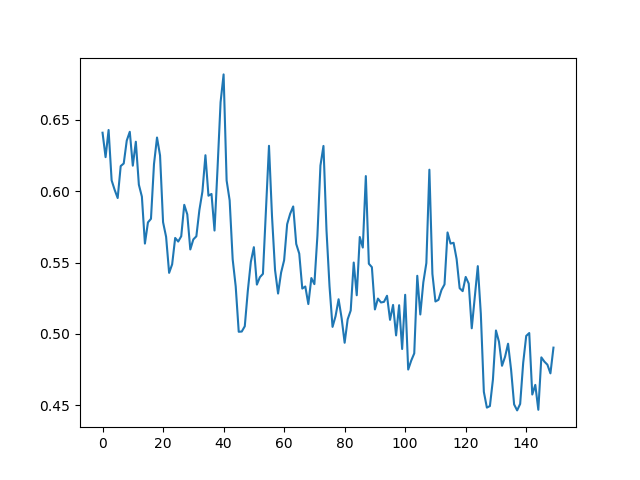

In [46]:
m0.train(X___,Y___,loop = 400)

<IPython.core.display.Javascript object>


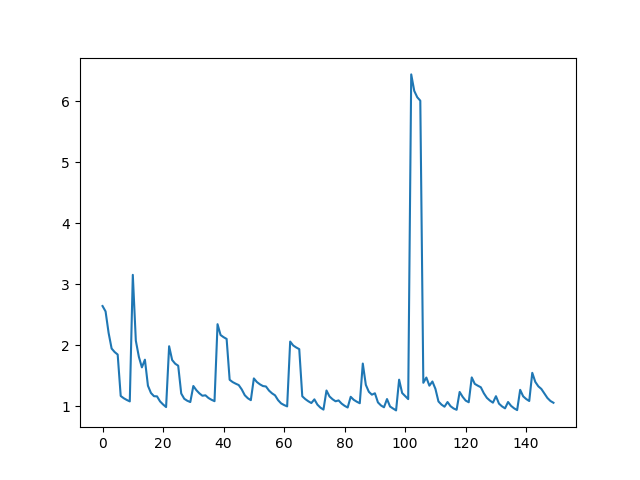

loop: 38 total: 152


In [69]:
m0.minib_train(X_tr,Y_tr,bloop = 4,bsize = 512)

In [51]:
m0.sess.close()

In [42]:
m0.test(X_tr,Y_tr)

AttributeError: 'model_0A' object has no attribute 'test'

In [43]:
m0.test(dx["X_te"],dx["Y_te"].reshape(-1,1))

AttributeError: 'model_0A' object has no attribute 'test'

In [44]:
m0.test(X_te,Y_te)

AttributeError: 'model_0A' object has no attribute 'test'

In [70]:
Y_ = m0.sess.run(m0.OUP,feed_dict = {m0.X:X_te})
(abs(Y_-Y_te) < 0.015).sum()/len(Y_) , len(Y_)

(0.63642882753675156, 2789)

In [35]:
Y_

array([[ 0.01127368],
       [ 0.02172538],
       [ 0.00590065],
       ..., 
       [ 0.00284272],
       [-0.00036916],
       [-0.00123109]], dtype=float32)

In [71]:
m0.save()

In [72]:
Y_yrd = dx2["Y_te"].reshape(-1,1)
X_yrd = dx2["X_te"]

In [73]:
YY_yrd = m0.sess.run(m0.OUP,feed_dict = {m0.X:X_yrd})

In [74]:
(abs(YY_yrd - Y_yrd)<0.02).sum()/len(YY_yrd)

0.5714285714285714

In [30]:
(dx3["Y_tr"]).std()/(dx3["Y_tr"]).mean(),(dx2["Y_tr"]).std()/(dx2["Y_tr"]).mean(),(dx["Y_tr"]).std()/(dx["Y_tr"]).mean()

(1.6284891701583128, 1.6479000318734176, 1.0540684506881759)